# Bankruptcy Risk Prediction

The Taiwan Economic Journal (TEJ) collected data on companies between the years 1999 to 2009. Crucially, the TEJ also recorded which companies went bankrupt during the associated time period. Featured on the UCI Machine Learning Repository, the resulting dataset provides a useful training ground for imbalanced classification and financial data science. Here, we'll build, test, and tune various ML models for predicting bankruptcy. At the end, we'll include a short section on how to adapt this model for a hypothetical business use-case.

In [2]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

# fetch dataset
taiwanese_bankruptcy_prediction = fetch_ucirepo(id=572)

# Load data (as pandas dataframes)
X = taiwanese_bankruptcy_prediction.data.features
y = taiwanese_bankruptcy_prediction.data.targets

# Strip leading and trailing spaces from column names
X.columns = X.columns.str.strip()

df = X.copy()
df['Bankrupt?'] = y

## EDA

Let's take a quick look at the shape of our dataset and the variables (i.e. predictors and target) present. As we'll see later, many of our predictors have clear financial meaning (e.g. they're profitability or credit ratios), so we can impose monotonicity constraints for increased interpretability or regulatory compliance.

In [3]:
print("Dataset Shape:", df.shape)
print("Variable Names:\n", df.columns)

Dataset Shape: (6819, 96)
Variable Names:
 Index(['ROA(C) before interest and depreciation before interest',
       'ROA(A) before interest and % after tax',
       'ROA(B) before interest and depreciation after tax',
       'Operating Gross Margin', 'Realized Sales Gross Margin',
       'Operating Profit Rate', 'Pre-tax net Interest Rate',
       'After-tax net Interest Rate',
       'Non-industry income and expenditure/revenue',
       'Continuous interest rate (after tax)', 'Operating Expense Rate',
       'Research and development expense rate', 'Cash flow rate',
       'Interest-bearing debt interest rate', 'Tax rate (A)',
       'Net Value Per Share (B)', 'Net Value Per Share (A)',
       'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons',
       'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)',
       'Operating Profit Per Share (Yuan ¥)',
       'Per Share Net profit before tax (Yuan ¥)',
       'Realized Sales Gross Profit Growth Rate',
       'Operating P

We also note that the dataset doesn't have any missing values present, which makes our lives a bit easier.

In [4]:
missing_values = df.isnull().sum()
print("Columns with Missing Values:", df.columns[missing_values > 0])

Columns with Missing Values: Index([], dtype='object')


Let's also take a look at how imbalanced our target is!

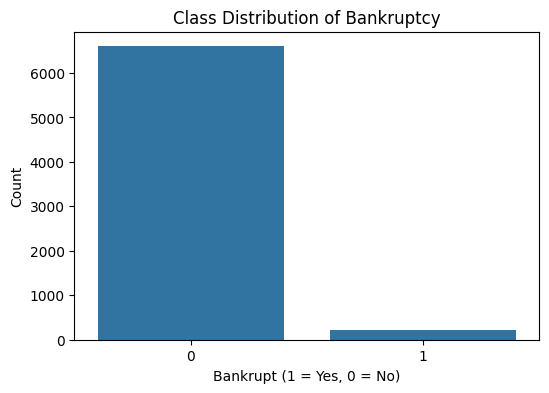


Class Distribution (%):
 Bankrupt?
0    96.77372
1     3.22628
Name: proportion, dtype: float64


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x="Bankrupt?", data=df)
plt.title("Class Distribution of Bankruptcy")
plt.xlabel("Bankrupt (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.show()

# Percentage of bankrupt vs non-bankrupt firms
class_counts = df["Bankrupt?"].value_counts(normalize=True) * 100
print("\nClass Distribution (%):\n", class_counts)

Note that we have **far** fewer bankrupt companies than non-bankrupt ones. This leads to accuracy being an incredibly misleading metric: if we always guess the majority class, we'll be right about $96.8\%$ of the time! Instead, we'll be applying **AUROC** (Area Under the Receiver-Operating Characteristic Curve) to assess the quality of our models. Here, AUROC measures the probability that a bankrupt company will be assigned a higher risk score than a non-bankrupt company, giving us an easily interpretable scoring metric. More importantly, AUROC is robust to class imbalances while being a semi-proper scoring metric. In other words, a high AUROC (unlike a high accuracy score) tells us something about the quality of our **probability estimates**, not the quality of our **classification choices.** [As noted by statistician Frank Harrell, this is especially important because it allows us to optimize for the statistical quality of our model and the needs of our (business) use-case separately.](https://www.fharrell.com/post/classification/) See more on this in the section titled "Decision Theory -- Thinking about Business Use-Cases."

Now let's take a look at how strongly correlated some of our variables are!

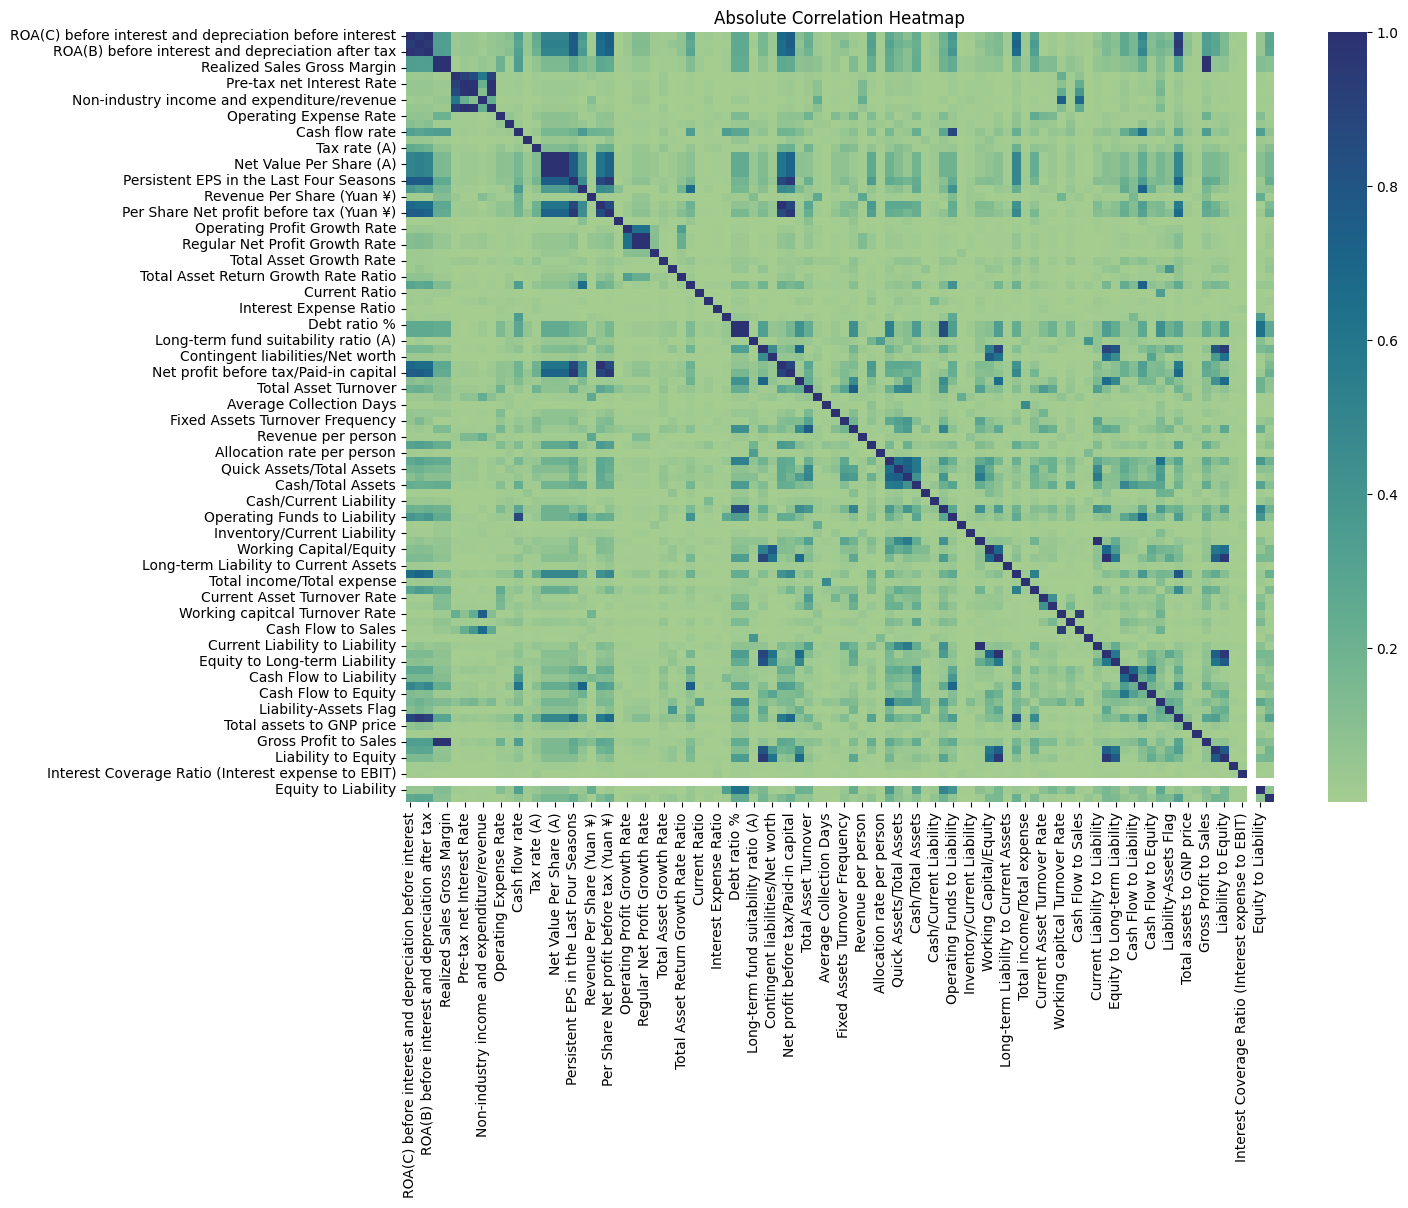

In [6]:
import numpy as np

plt.figure(figsize=(14, 10))
corr_matrix = df.corr()
sns.heatmap(np.abs(corr_matrix), cmap="crest")
plt.title("Absolute Correlation Heatmap")
plt.show()

The numerous dark patches on the correlation heatmap indicate groups of variables that are strongly correlated (either negatively or positively). This suggests that we may be able to apply feature selection to arrive at a more parsimonious, generalizable, and interpretable model. Let's also get a visual sense of how our predictors are distributed.

<Figure size 1500x1200 with 0 Axes>

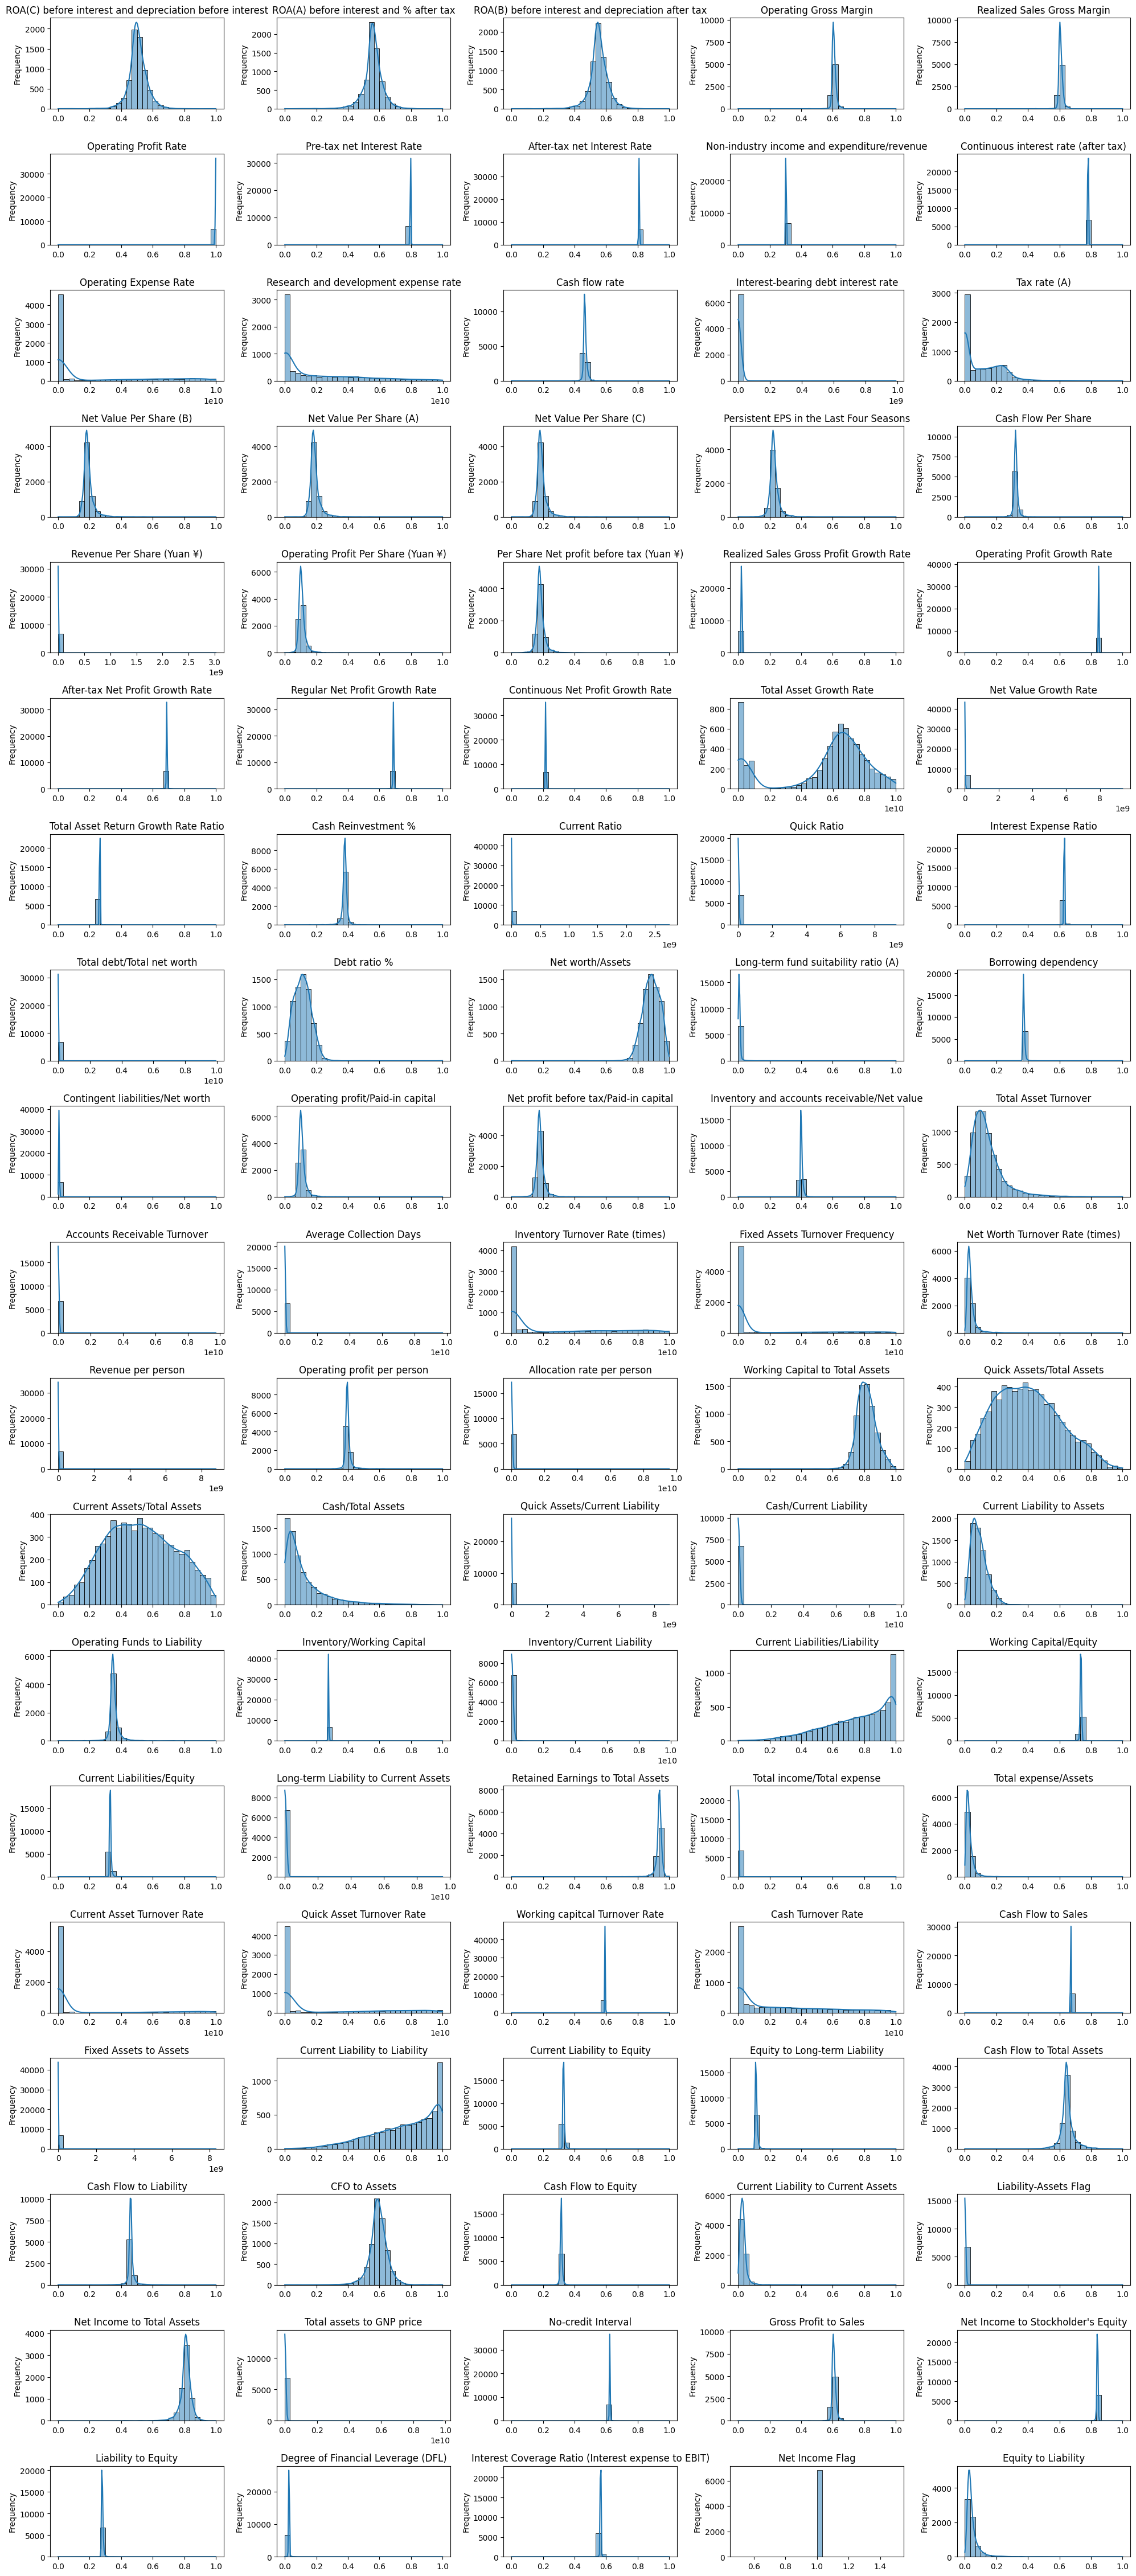

In [7]:
plt.figure(figsize=(15, 12))

num_cols = 5
num_features = len(X.columns)

# Create subplots
fig, axes = plt.subplots(nrows=(num_features // num_cols) + 1, ncols=num_cols, figsize=(20, num_features * 0.5))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Loop through each column and plot a histogram
for i, col in enumerate(X.columns):
    sns.histplot(X[col].dropna(), bins=30, kde=True, ax=axes[i])  # KDE for smooth density estimation
    axes[i].set_title(col)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Frequency")

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

We note that some of these features have skewed distributions, but that isn't an immediate problem. Nevertheless, it's a useful observation to keep in mind if we'd like to perform diagnostics and improve a logistic model. There are also certain variables which seem quite extraneous (e.g. net income flag) because almost all the data points have the same value, so models which perform automatic feature selection will become especially useful.

## Building and Testing Prediction Models!

### Logistic Regression and its Variants

We begin with a standard baseline: a classic logistic regression model! Let's apply 5-fold cross-validation to assess its AUROC on unseen data.

In [8]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression

logistic_unpenalized = LogisticRegression(penalty=None,
                                          max_iter=1000,
                                          solver='lbfgs')

# We use StandardScaler to improve convergence
log_pipe = Pipeline([('scale', StandardScaler()), ('clf', logistic_unpenalized)])

auc_unpenalized = cross_val_score(log_pipe, X, np.ravel(y), cv=5, scoring="roc_auc").mean()
print("AUROC (Unpenalized Logistic Regression):", auc_unpenalized)


AUROC (Unpenalized Logistic Regression): 0.8453719530406414


With our baseline established, let's see if we can do better. We'll first use $L2$-penalized logistic regression and apply GridSearchCV to tune the regularization strength. $L1$-penalized logistic regression will likely work better (as we expect feature sparsity to be helpful here), but we'll test $L2$-penalization first to cover all our bases.

In [9]:
# Hyperparameter grid
param_grid_logistic = {
    "clf__C": [1e-4, 0.001, 0.01, 0.1, 1]  # Regularization strength
}

logistic_l2 = LogisticRegression(penalty="l2",
                                 solver="liblinear",
                                 max_iter=1000)

l2_log_pipe = Pipeline([('scale', StandardScaler()), ('clf', logistic_l2)])

grid_search_l2_logistic = GridSearchCV(
    l2_log_pipe, param_grid=param_grid_logistic,
    cv=5, scoring="roc_auc", n_jobs=-1, verbose=1
)

grid_search_l2_logistic.fit(X, np.ravel(y))
print("Best C (L2 Logistic Regression):", grid_search_l2_logistic.best_params_["clf__C"])
print("Best AUROC (L2 Logistic Regression):", grid_search_l2_logistic.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best C (L2 Logistic Regression): 0.0001
Best AUROC (L2 Logistic Regression): 0.9168789173699918


Wow, $L2$-penalization results in a dramatic increase in AUROC! Let's try $L1$-penalization next.

In [10]:
logistic_l1 = LogisticRegression(penalty="l1",
                                 solver="liblinear",
                                 max_iter=1000)


l1_log_pipe = Pipeline([('scale', StandardScaler()), ('clf', logistic_l1)])

grid_search_l1_logistic = GridSearchCV(
    l1_log_pipe, param_grid=param_grid_logistic,
    cv=5, scoring="roc_auc", n_jobs=-1, verbose=1
)

grid_search_l1_logistic.fit(X, np.ravel(y))

print("Best C (L1 Logistic Regression):", grid_search_l1_logistic.best_params_["clf__C"])
print("Best AUROC (L1 Logistic Regression):", grid_search_l1_logistic.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best C (L1 Logistic Regression): 0.01
Best AUROC (L1 Logistic Regression): 0.9229039577315648


Impressive! An AUROC of $92.3\%$ is relatively respectable. Let's look at the features deemed most important by this model after re-training on the whole dataset.

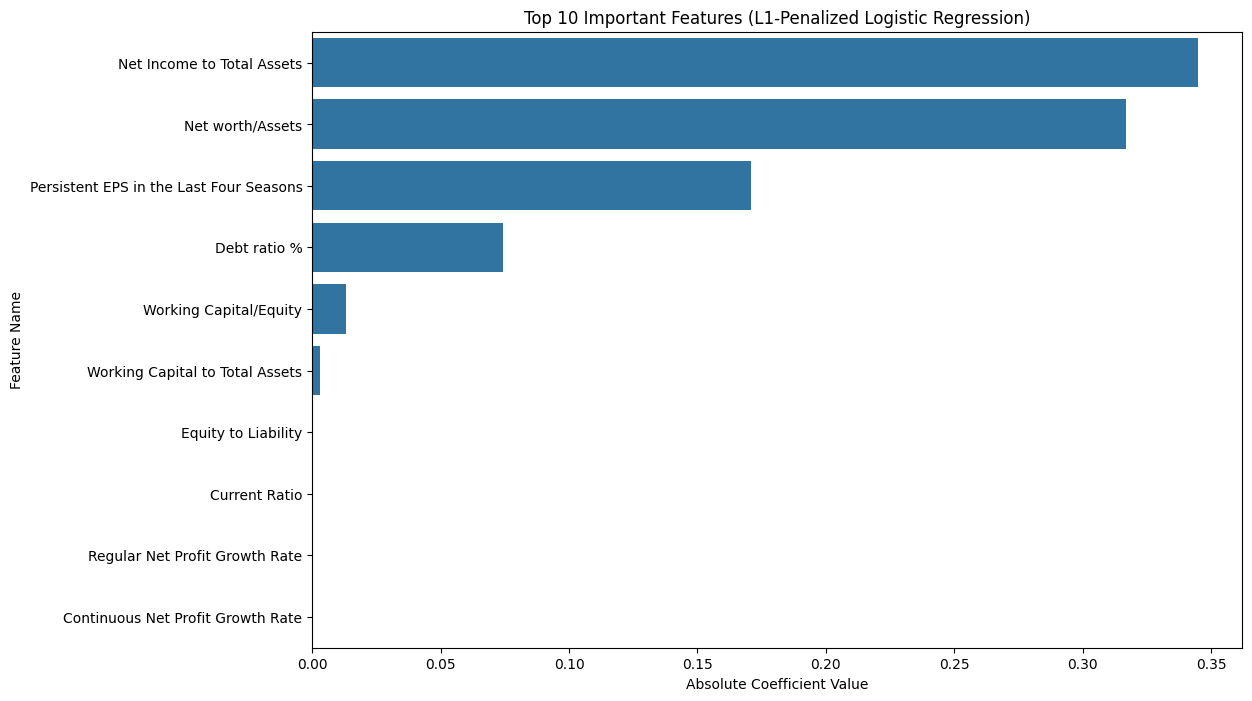

In [11]:
best_logistic = grid_search_l1_logistic.best_estimator_
best_logistic.fit(X, np.ravel(y))

# Get absolute coefficients and sort by importance
coefficients = best_logistic.named_steps['clf'].coef_[0]
feature_importance = np.abs(coefficients)
feature_names = np.array(X.columns)
sorted_idx = np.argsort(feature_importance)[::-1][:10]  # Top 10 features

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance[sorted_idx], y=feature_names[sorted_idx])
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature Name")
plt.title("Top 10 Important Features (L1-Penalized Logistic Regression)")
plt.show()

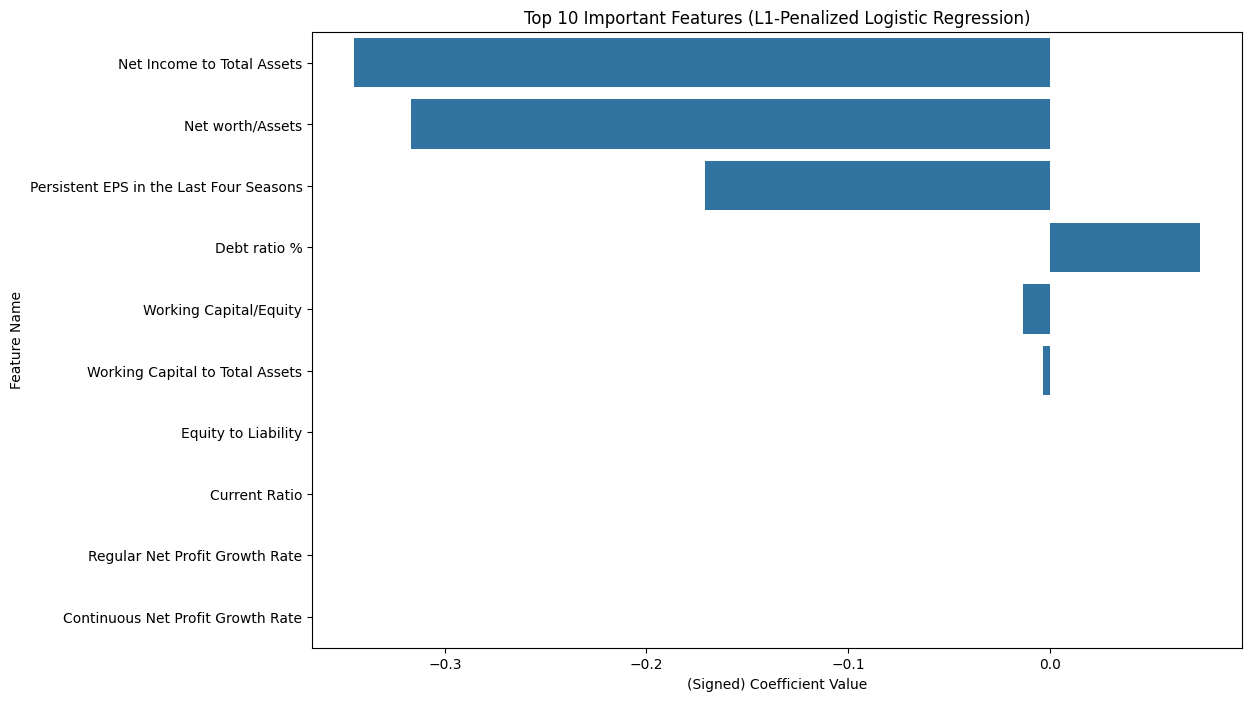

In [12]:
# Plot signed coefficients
plt.figure(figsize=(12, 8))
sns.barplot(x=coefficients[sorted_idx],
            y=feature_names[sorted_idx])
plt.xlabel("(Signed) Coefficient Value")
plt.ylabel("Feature Name")
plt.title("Top 10 Important Features (L1-Penalized Logistic Regression)")
plt.show()

We've successfully culled a set of 95 predictors to a set of just 5 crucial predictors! From here, we might want to perform model diagnostics to address any non-linearities in our logistic model. This would be the logical next step in a business use-case, but we'll proceed to trying non-linear methods for instructive purposes.

### Random Forests

We'll jump to using random forests next; its automatic feature selection and robustness to overfitting are rather attractive here.

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf_non_mono = RandomForestClassifier(random_state=42, n_jobs=-1)

# Define the hyperparameter grid to search over
rf_param_dist = {
    'n_estimators': np.arange(10, 201, 10),
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up the RandomizedSearchCV
random_search_rf_non_mono = RandomizedSearchCV(estimator=rf_non_mono,
                                               param_distributions=rf_param_dist,
                                               n_iter=25, cv=5, scoring="roc_auc", n_jobs=-1,
                                               random_state=42)

# Fit the model to the training data
random_search_rf_non_mono.fit(X, np.ravel(y))
print("Best AUROC (Non-Monotonic RF):", random_search_rf_non_mono.best_score_)


Best AUROC (Non-Monotonic RF): 0.9247516927842071


Hm, the results here are a bit underwhelming. Despite being a much more complicated model than logistic regression, our random forest's AUROC score is only marginally better than our best logistic model. Perhaps this effect arises from the monotonic relationship between our predictors and our target. Indeed, greater profitability decreases bankruptcy risk while higher debt increases it, and several of our predictors are profitability/leverage ratios. Thus, maybe we can apply monotonicity constraints to improve the interpretability and/or performance of our RF model! Let's take the signs of the features chosen from our $L1$-penalized logistic model and throw it into a monotonic random forest. (We can therefore view this monotonic RF as a non-linear counterpart to our best logistic regression model.)

In [14]:
import numpy as np

# Set monotonic constraints
constrained_features = {
    "Net Income to Total Assets": -1,
    "Net worth/Assets": -1,
    "Persistent EPS in the Last Four Seasons": -1,
    "Working Capital/Equity": -1,
    "Working Capital to Total Assets": -1,
    "Debt ratio %": 1
}


feature_order = X.columns.tolist()
constraint_array = np.array([constrained_features.get(feature, 0) for feature in feature_order])


# Set up monotonic RF
rf_mono = RandomForestClassifier(monotonic_cst=constraint_array, random_state=42, n_jobs=-1)
random_search_rf_mono = RandomizedSearchCV(estimator=rf_mono,
                                               param_distributions=rf_param_dist,
                                               n_iter=25, cv=5, scoring="roc_auc", n_jobs=-1,
                                               random_state=42)
random_search_rf_mono.fit(X, np.ravel(y))

print("Best AUROC (Monotonic RF):", random_search_rf_mono.best_score_)

Best AUROC (Monotonic RF): 0.9231832762632181


This AUROC score is indeed slightly superior to the AUROC score of our best logistic model, but it's worse than our original RF model. Perhaps the smoothness of the logistic model lends itself well to the inductive bias of the problem at hand, even though the linearity assumption of logistic regression may be false. Nevertheless, imposing monotonicity on RFs may be helpful if regulatory agencies enforce monotonicity for fairness reasons. Let's also visualize the feature importance values of our best RF model.

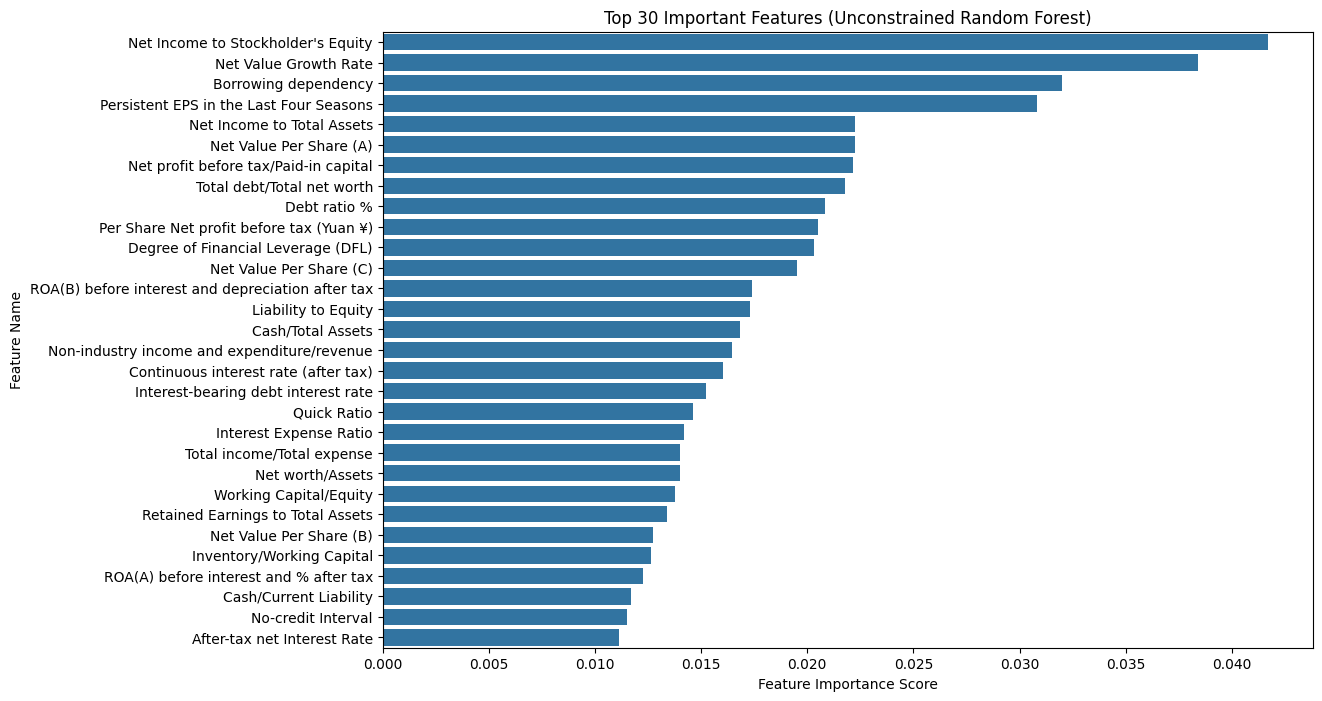

In [15]:
# Get feature importance values
best_rf = random_search_rf_non_mono.best_estimator_
feature_importance = best_rf.feature_importances_

# Sort by importance
sorted_idx = np.argsort(feature_importance)[::-1][:30]  # Select top 30 features

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance[sorted_idx], y=feature_names[sorted_idx])
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Name")
plt.title("Top 30 Important Features (Unconstrained Random Forest)")
plt.show()

### XGBoost

We'll progress to experimenting with XGBoost!

In [16]:
from xgboost import XGBClassifier

xgb_params = {
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]

}

xgb_non_mono = XGBClassifier()

random_search_xgb_non_mono = RandomizedSearchCV(xgb_non_mono, param_distributions = xgb_params,
                                       n_iter = 25, scoring = 'roc_auc',
                                       cv = 5, random_state=42)

random_search_xgb_non_mono.fit(X, np.ravel(y))

print("Best AUROC (Non-Monotonic XGBoost):", random_search_xgb_non_mono.best_score_)

Best AUROC (Non-Monotonic XGBoost): 0.9317281514921774


In [17]:
xgb_mono = XGBClassifier(monotone_constraints = tuple(constraint_array))

random_search_xgb_mono = RandomizedSearchCV(xgb_mono, param_distributions = xgb_params,
                                       n_iter = 25, scoring = 'roc_auc',
                                       cv = 5, random_state=42)


random_search_xgb_mono.fit(X, np.ravel(y))

print("Best AUROC (Monotonic XGBoost):", random_search_xgb_mono.best_score_)

Best AUROC (Monotonic XGBoost): 0.9321103724542968


Fantastic! The monotonic XGBoost model outperforms all previous models, including its unconstrained counterpart! (We note, however, that the monotonic XGBoost model does not significantly beat its unconstrained counterpart, but the enforcement of monotonicity enhances both interpretability and performance here, so it's certainly a win.) Let's take a look at the feature importance values of this model.

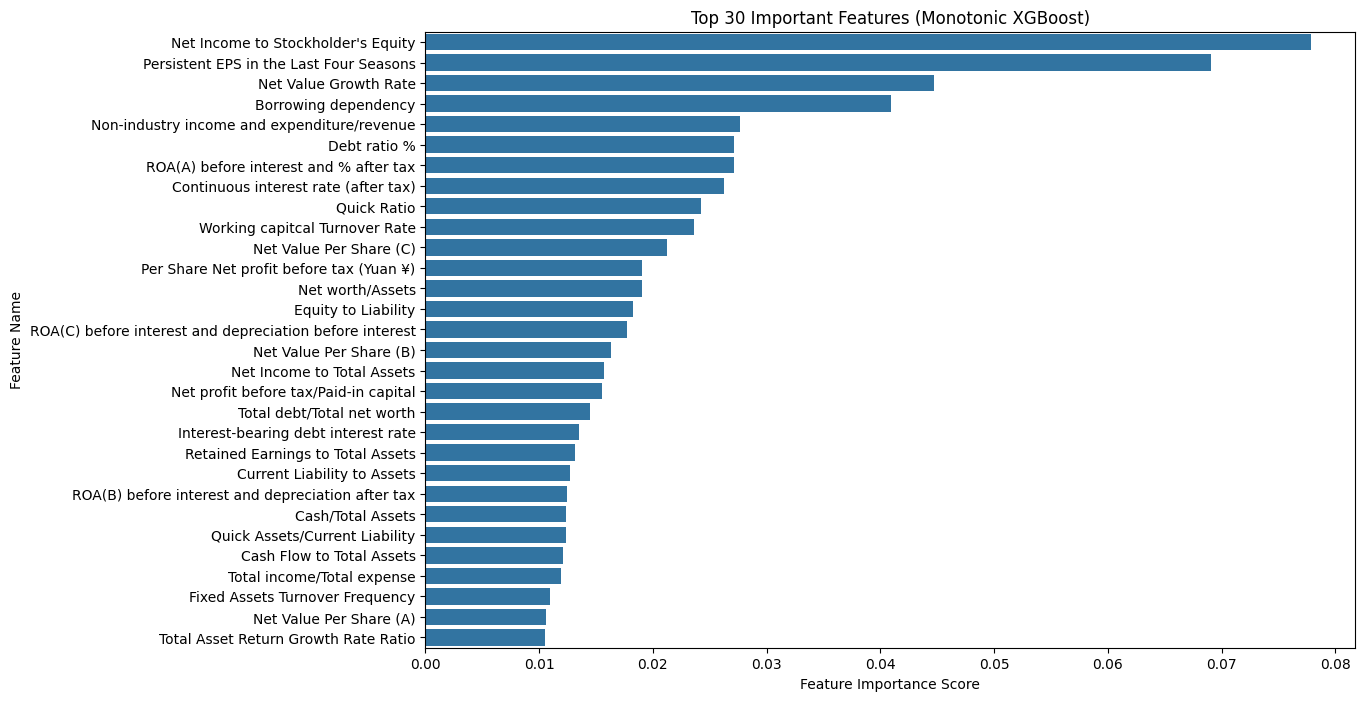

In [18]:
# Get feature importance values
best_xgb = random_search_xgb_mono.best_estimator_
feature_importance = best_xgb.feature_importances_

# Sort by importance
sorted_idx = np.argsort(feature_importance)[::-1][:30]  # Select top 30 features

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importance[sorted_idx], y=feature_names[sorted_idx])
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature Name")
plt.title("Top 30 Important Features (Monotonic XGBoost)")
plt.show()

## Decision Theory -- Thinking about Business Use-Cases

Great, we have a solid model, but how can we use this model to inform our decision-making? If we were a bank, for instance, we might want to use our model to decide which companies should receive a loan. Here, the cost of a false negative is *far* higher than that of a false positive (i.e., it's worse to misclassify a company that will go bankrupt than to misclassify a company that won't). With this in mind, we can use the probability estimates from our best model and plot out a ROC Curve using test data. From there, we can also determine the optimal decision threshold for approving or denying a loan. For the sake of an example, let's say that a false negative costs us 5 times more money than a false positive. [(This mirrors the cost matrix in the famous (Statlog) German Credit dataset.)](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data) We therefore want to minimize $$5 \cdot FN + FP,$$ where $FP$ is the number of false positives and $FN$ is the number of false negatives. (We note that Sklearn's TunedThresholdClassifierCV will use cross-validation to find the optimal threshold for us, but for instructive purposes, we'll find the optimal threshold manually. In an actual business use-case, however, TunedThresholdClassifierCV provides more robust threshold estimates.)






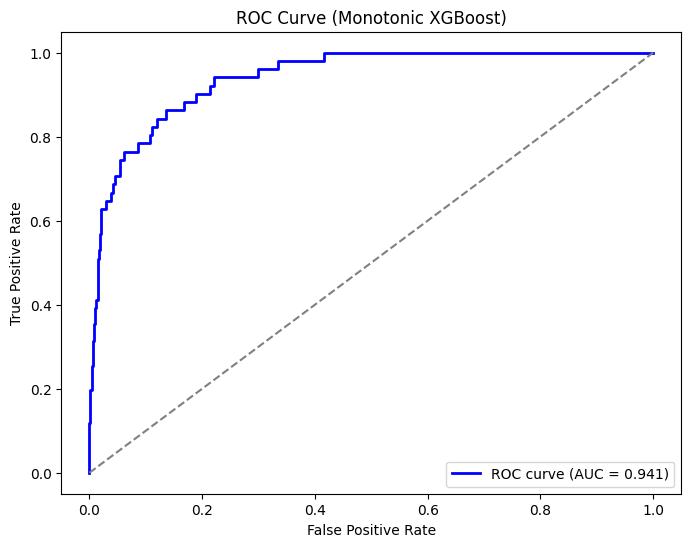

Optimal Decision Threshold: 0.2074


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, confusion_matrix

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit best model
best_xgb.fit(X_train, y_train)

# Predict probabilities for the positive class
y_probs = best_xgb.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line (random classifier)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Monotonic XGBoost)")
plt.legend(loc="lower right")
plt.show()

# Initialize cost array
costs = []

# Iterate through possible thresholds
for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)  # Convert probabilities to binary predictions
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()  # Get confusion matrix values

    cost = 5 * fn + fp  # Cost function
    costs.append(cost)

# Find the threshold that minimizes the cost function
optimal_idx = np.argmin(costs)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Decision Threshold: {optimal_threshold:.4f}")

We therefore reject a loan to a company if we think their probability of bankruptcy is at least $20.74\%.$